<h1>Udacity Self-Driving Car Nanodegree Program</h1>


<h2>Advanced Lane Finding Project</h2>
    
<b>The steps of this project are the following::</b>

<ol>
    <li>Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.</li>
    <li>Apply a distortion correction to raw images.</li>
    <li>Use color transforms, gradients, etc., to create a thresholded binary image.</li>
    <li>Apply a perspective transform to binary image ("birds-eye view").</li>
    <li>Detect lane pixels and fit to find the lane boundary.</li>
    <li>Determine the curvature of the lane and vehicle position with respect to center.</li>
    <li>Warp the detected lane boundaries back onto the original image.</li>
    <li>Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.</li>
</ol>

In [21]:
# import all needed libraries
import numpy as np 
import cv2 
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from moviepy.editor import VideoFileClip
import os 
import pickle

%matplotlib inline

<h3>Camera Calibration and Undistortion of Images</h3>

In [22]:
nx = 9
ny = 6
img_dir_path = './camera_cal/calibration*.jpg'

# Make a list of calibration images
images = glob.glob(img_dir_path)
    
def find_img_obj_points():
    # 1. Prepare object points like (0,0,0), (1,0,0), ..., (8,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) #x,y coordinates 

    # 2. Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    image_size = None
    
    # 3. Create a figure for plotting imgs
    f, axes = plt.subplots(1,2,figsize=(30,30))
    
    # 4. Step through the list and search for chessboard corners
    for i, fname in enumerate(images):
        origin_img = cv2.imread(fname)
        if i==2: 
            image_size = (origin_img.shape[0], origin_img.shape[1])
            # Plotting the original Image
            axes[0].set_title('Original Image', fontsize=20)
            axes[0].imshow(origin_img)
        gray = cv2.cvtColor(origin_img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners in distorted img
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
        
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            cv2.drawChessboardCorners(origin_img, (nx,ny), corners, ret)
            if i==2: 
                # Plotting original Image with Chessboard Corners
                axes[1].set_title('Image with Chessboard Corners', fontsize=20)
                axes[1].imshow(origin_img)
        
    return objpoints, imgpoints, image_size

In [23]:
def calc_calibration_params():
    """Calculate and return camera matrix and distortion coefficients."""
    path = "camera_cal/dist_pickle.p"
    dist_pickle = {}
    
    if not os.path.isfile(path): 
        obj_points, img_points, img_shape = find_img_obj_points()
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_shape, None, None)
 
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        pickle.dump(dist_pickle, open(path, "wb"));
    else: 
        dist_pickle = pickle.load(open("camera_cal/dist_pickle.p", "rb" ))
        mtx = dist_pickle["mtx"]
        dist = dist_pickle["dist"]
    
    return mtx, dist

In [24]:
def undistort(image):

    mtx, dist = calc_calibration_params()
    dst_img = cv2.undistort(image, mtx, dist, None, mtx)
    return dst_img

Text(0.5, 1.0, 'Undistorted Image')

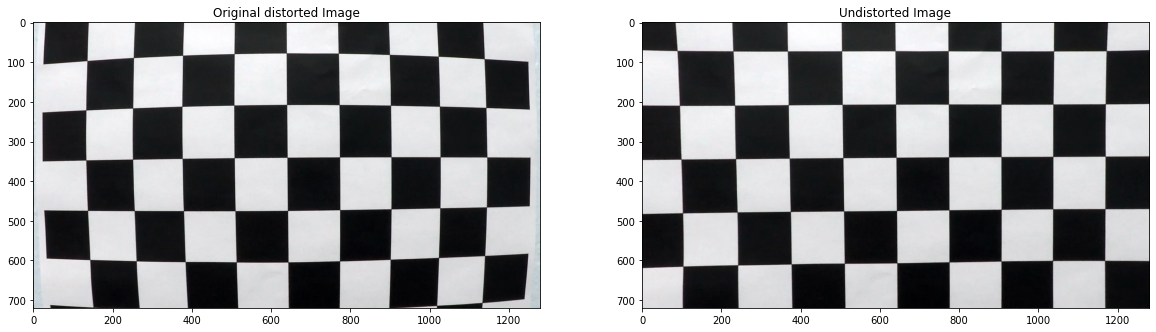

In [25]:
origin_img = cv2.imread(images[6])
undist_img = undistort(origin_img)

fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].imshow(origin_img)
axes[0].set_title('Original distorted Image')
axes[1].imshow(undist_img)
axes[1].set_title('Undistorted Image')

<h3>Create thresholded binary Image </h3>

<h6> Building the printing pipeline for better readability and maitenance </h6>

In [118]:
def pipeline(op=None):
    
    test_images = []
    test_imgs_all = glob.glob('test_images/test*.jpg')
    # use only the first two images for tests
    test_images.append(test_imgs_all[0])
    test_images.append(test_imgs_all[5])

    print ('test_images ', len(test_images))
    n = 0
    for img in test_images:
        img = cv2.imread(img)
        bgr_img = bgr_to_rgb(img)
        if op == 'Lane Mapping':            
            undistorted = undistort(img)
            thresholded = combined_threshold(undistorted) 
            binary_warped = original2bird_eye(thresholded)
            lines_img, pl, lfx, rfx, lf, rf, lli, rli =  sliding_windows(binary_warped, plot=False)

            final_img = draw_green_lanes(img, binary_warped, lf, rf)

            plotter(bgr_img, cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB), op, n)
            plt.savefig('output_images/lane_mapping.png'.format(op), bbox_inches="tight")
        if op == 'Undistorted':
            new_img = undistort(img)
            plotter(bgr_img, cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB), op, n)
            plt.savefig('output_images/undistorted.png'.format(op), bbox_inches="tight")
            #break
        if op == 'Sobel X':
            new_img = undistort(img)
            new_img = abs_sobel_thresh(img,thresh=(35,255))
            plotter(bgr_img, new_img, op, n)
            plt.savefig('output_images/sobel_x.png'.format(op), bbox_inches="tight")
            break
        if op == 'Sobel Y':
            new_img = undistort(img)
            new_img = abs_sobel_thresh(img,orient='y',thresh=(35,255))
            plotter(bgr_img, new_img, op, n)
            plt.savefig('output_images/sobel_y.png'.format(op), bbox_inches="tight")
            break
        if op == 'Gradient Magnitude':
            new_img = undistort(img)
            new_img = mag_thresh(img)
            plotter(bgr_img, new_img, op, n)
            plt.savefig('output_images/gradient_magnitude.png'.format(op), bbox_inches="tight")
            break
        if op == 'Gradient Direction':
            new_img = undistort(img)
            new_img = dir_threshold(img)
            plotter(bgr_img, new_img, op, n)
            plt.savefig('output_images/gradient_direction.png'.format(op), bbox_inches="tight")
            break
        if op == 'Color Thresholds':
            new_img = undistort(img)
            new_img = hls_select(img)
            plotter(bgr_img, new_img, op, n)
            plt.savefig('output_images/color_thresholds.png'.format(op), bbox_inches="tight")
            break
        if op == 'Multi-Thresholded Binary':
            new_img = undistort(img)
            new_img = combined_threshold(new_img)
            plotter(bgr_img, new_img, op, n)
            plt.savefig('output_images/thresholded_binary.png'.format(op), bbox_inches="tight")
            #break
        if op == 'Region Masking':
            new_img = undistort(img)
            new_img = combined_thresholds(new_img)
            new_img = region_of_interest(new_img)
            plotter(bgr_img, new_img, op, n)
            plt.savefig('output_images/region_masked.png'.format(op), bbox_inches="tight")
            #break
        if op == 'Perspective Transform':
            new_img = undistort(img)
            new_img = combined_threshold(new_img)
            #new_img = region_of_interest(new_img)
            new_img = original2bird_eye(new_img)
            plotter(bgr_img, new_img, op, n)
            plt.savefig('output_images/perspective_transform.png'.format(op), bbox_inches="tight")
            #break
        if op == 'Sliding Window':
            new_img = undistort(img)
            binary_img= combined_threshold(new_img)
            binary_warped= original2bird_eye(binary_img)
            
            out_img, left_fit, right_fit, left_fitx, right_fitx = find_lines(binary_warped, plot=True)
            
            plotter(bgr_img, out_img, op, n)
            ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
            plt.savefig('output_images/sliding_windows.png'.format(op), bbox_inches="tight")
            #break
        if op == 'Shaded Lanes':
            undistorted_img = undistort(img)
            thresholded_img = combined_threshold(undistorted_img)
            bird_eyed_img= original2bird_eye(thresholded_img)
            #def use_last_frame(binary_warped, left_fit, right_fit):
            _, left_fit, right_fit, _, _ = find_lines(bird_eyed_img, plot=False)

            left_fitx, right_fitx, py, _, _, _, _, _, _, lli, rli = use_last_frame(bird_eyed_img,left_fit,right_fit)
            #out_img, left_fit, right_fit, left_fitx, right_fitx = find_lines(bird_eyed_img, plot=True)
            shaded_img = visualize_lane_lines(bird_eyed_img,left_fitx, right_fitx, pl,lli,rli) 
            #def visualize_lane_lines(binary_warped, left_fitx, right_fitx, ploty, left_lane_inds, right_lane_inds):
            plotter(bgr_img, shaded_img, op, n)
            plt.plot(lfx, pl, color='yellow')
            plt.plot(rfx, pl, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
            plt.savefig('output_images/shaded_lanes.png'.format(op), bbox_inches="tight")
            #break
        if op == 'Radius of Curvature in Pixels':
            new_img = undistort(img)
            new_img = combined_thresholds(new_img)
            new_img, M, Minv = transform_perspective(new_img)
            windows_img, ploty, left_fitx, right_fitx, left_fit, right_fit, leftx, rightx,leftx_base, rightx_base = sliding_windows(new_img)
            left_curverad, right_curverad = roc_in_pixels(ploty, left_fit, right_fit, leftx, rightx)
            print('Test Image {0}\nLeft Radius of Curvature: {1:2f} pixels\nRight Radius of Curvature: {2:2f} pixels\n'.format(n+1, left_curverad, right_curverad))
            break
        if op == 'Radius of Curvature in Meters':
            new_img = undistort(img)
            new_img = combined_thresholds(new_img)
            new_img, M, Minv = transform_perspective(new_img)
            windows_img, ploty, left_fitx, right_fitx, left_fit, 
            right_fit, leftx,rightx, leftx_base, rightx_base = sliding_windows(new_img)
            left_curverad, right_curverad = roc_in_meters(ploty, left_fit, right_fit, leftx, rightx)
            print('Test Image {0}\nLeft Radius of Curvature: {1:2f} meters\nRight Radius of Curvature: {2:2f} meters\n'.format(n+1, left_curverad, right_curverad))
            break

        if op == "Histogram":
            img = undistort(img)
            img = original2bird_eye(img)
            f, axes= plt.subplots(1,3,figsize=(20,5))
            index=0
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            axes[0].imshow(img)
            axes[0].set_title("Original Wraped Image",fontsize=15)
            combinedImage=combined_threshold(img)
            axes[1].imshow(combinedImage,cmap="gray")
            axes[1].set_title("Thresholded Binary Image",fontsize=15)
            histogram = get_histogram(combinedImage)
            axes[2].plot(histogram)
            axes[2].set_title("Histogram",fontsize=15)
        
        if op == 'Full': 
            undistorted = undistort(img)
            thresholded = combined_threshold(undistorted) 
            binary_warped = original2bird_eye(thresholded)
            out_img, pl, lfx, rfx, lf, rf, lli, rli =  sliding_windows(binary_warped)
            final_img = draw_green_lanes(img,binary_warped, lf, rf)
            
            radius, distance = CalculateRadiusOfCurvature(binary_warped,lf,rf)
            cv2.putText(final_img,"Radius of Curvature is " + str(int(radius))+ "m", (100,100), 2, 1, (255,255,0),2)
            #print(distance)
            cv2.putText(final_img,"Distance from center is {:2f}".format(distance)+ "m", (100,150), 2, 1, (255,255,0),2)
            ts = time.time()
            st = datetime.datetime.fromtimestamp(ts).strftime('%Y%m%d %H%M%S')

            cv2.imwrite('./Output_1/'+str(st)+'.jpg',bgr_img)

            cv2.imwrite('./Output_1/'+str(st)+'_o.jpg',final_img)
            new_combined_img = np.dstack((thresholded*255,thresholded*255,thresholded*255))
            final_img[100:240,1000:1200, :]= cv2.resize(new_combined_img, (200,140))
            
            plotter(bgr_img, cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB), op, n)
            plt.savefig('output_images/pipeline.png'.format(op), bbox_inches="tight")

            
        n += 1

In [119]:
pipeline(op='Shaded Lanes')

test_images  2


UnboundLocalError: local variable 'pl' referenced before assignment

In [27]:
def bgr_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def plotter(test_img, new_img, plot_title=None, n=0):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    f.tight_layout()
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15)
    ax1.imshow(test_img)
    ax1.set_title('Original Image:', fontsize=15)
    ax2.imshow(new_img, cmap='gray')
    ax2.set_title('{0} Test {1}:'.format(plot_title, n+1), fontsize=15)

test_images  2


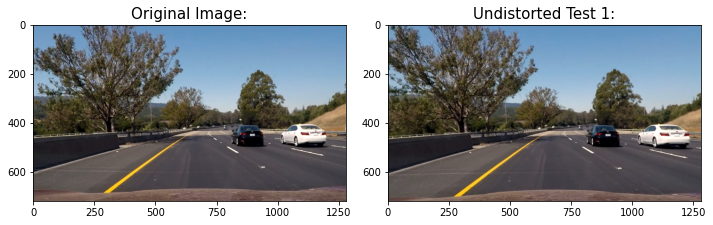

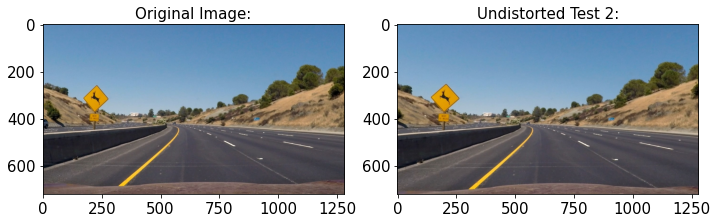

In [28]:
pipeline(op='Undistorted')

<h6> Functions to work with direvatives of images in x and y directions. </h6>


In [29]:
# function to return thresholded gradient based binary output 
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)): 
    # 1. Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2. Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x': 
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else: 
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3. Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4. Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(abs_sobel * 255 / np.max(abs_sobel))
    
    # 5. Threshold the scaled_sobel and create a binary output
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

test_images  2


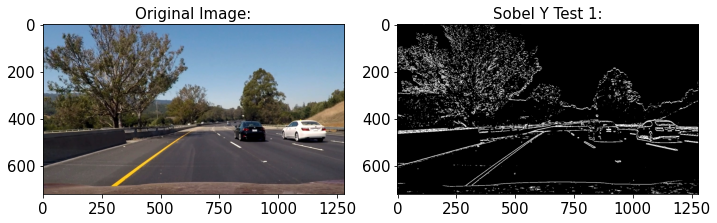

In [30]:
pipeline(op='Sobel Y')

test_images  2


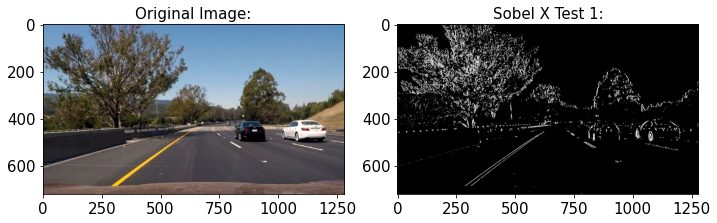

In [31]:
pipeline(op='Sobel X')

In [32]:
# function to return magnitute of derivatives thresholded binary output
def mag_thresh(img, sobel_kernel=3, thresh=(50,255)): 
    # 1. Convert to grayscale 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2. Take the gradient in x and y separately 
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3. Calculate the magnitude
    magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    
    # 4. Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_mag = np.uint8(magnitude * 255 / np.max(magnitude))
    
    # 5. Create a binary mask where magnitude thresholds are met 
    binary_output = np.zeros_like(scaled_mag)
    binary_output[(scaled_mag > thresh[0]) & (scaled_mag <= thresh[1])] = 1
    
    return binary_output

test_images  2


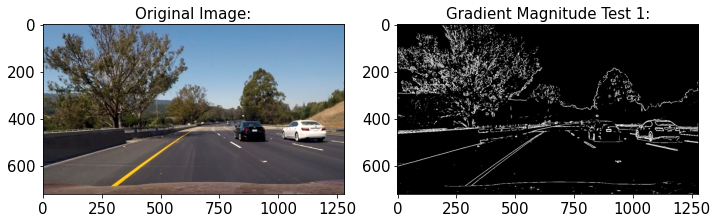

In [33]:
pipeline(op='Gradient Magnitude')

In [34]:
# function to return direction of derivatives thresholded binary output
def dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1.1)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)

    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(gray)
    binary_output[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1

    return binary_output

test_images  2


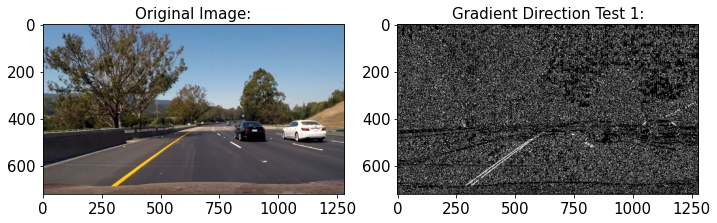

In [35]:
pipeline(op='Gradient Direction')

In [55]:
# Get pixel values for white colors from all RGB channels 
def rgb_white(img):
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]

    binary_output = np.zeros_like(r)
    binary_output[(r >= 210) & (g >= 200) & (b >= 190)] = 1
    return binary_output

# Filter out the lower pixel values in all RGB channels to avoid shadow
def suppress_shadow(img):
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]

    binary_output = np.zeros_like(r)
    binary_output[(r > 30) | (g > 30) | (b > 30)] = 1
    return binary_output

# Convert RGB to HLS color space and return a thresholded channel
def hls_select(img, selected='s', thresh=(80, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    # 2) Apply a threshold to the selected channel
    idx = {'h': 0, 'l': 1, 's': 2}[selected.lower()]
    channel = hls[:, :, idx]

    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output

test_images  2


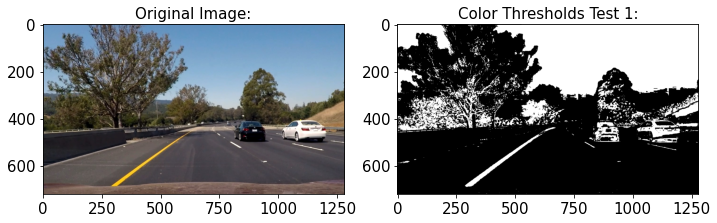

In [56]:
pipeline(op='Color Thresholds')

In [57]:
def combined_threshold(image):
    """return the binary warp result of the image"""
    ksize = 5

    # Apply each of the thresh-holding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(50, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(100, 255))
    s_channel = hls_select(image, selected='s', thresh=(180, 255)) & suppress_shadow(image)
    white = rgb_white(image)
    shadowed_yellow = hls_select(image, selected='h', thresh=(18, 63)) & \
                      hls_select(image, selected='s', thresh=(55, 255)) & \
                      hls_select(image, selected='l', thresh=(0, 140))

    combined = gradx | grady | s_channel | shadowed_yellow | white
    return combined

test_images  2


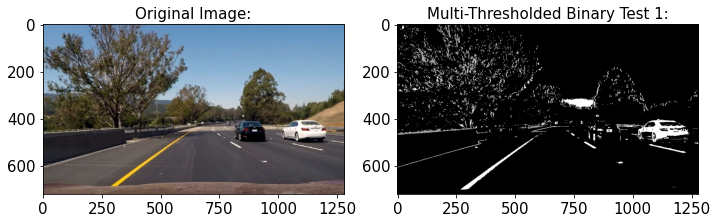

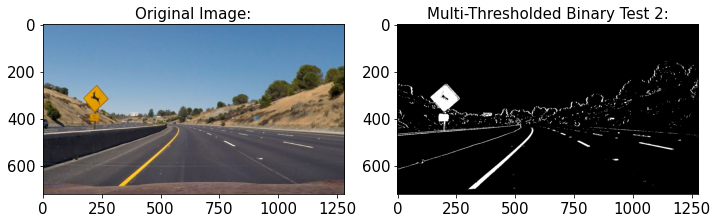

In [58]:
pipeline(op='Multi-Thresholded Binary')

<h3>Perspective Transform</h3> 

In [59]:
def bgr_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def plotter(test_img, new_img, plot_title=None, n=0):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    f.tight_layout()
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15)
    ax1.imshow(test_img)
    ax1.set_title('Original Image:', fontsize=15)
    ax2.imshow(new_img, cmap='gray')
    ax2.set_title('{0} Test {1}:'.format(plot_title, n+1), fontsize=15)

In [60]:
# Source matrix
src = np.array([[580, 460],
                [203, 720],
                [1127, 720],
                [705, 460]], dtype=np.float32)

# Target matrix to transform to
dst = np.array([[320, 0],
                [320, 720],
                [960, 720],
                [960, 0]], dtype=np.float32)

source = np.float32([[490, 482],[810, 482],
                  [1250, 720],[40, 720]])
destination = np.float32([[0, 0], [1280, 0], 
                 [1250, 720],[40, 720]])
left_end, right_end = 250, 1080

# transform matrix
trans_matrix = cv2.getPerspectiveTransform(source, destination)
invert_matrix = cv2.getPerspectiveTransform(destination, source)

def original2bird_eye(image):
    return cv2.warpPerspective(image, trans_matrix, image.shape[1::-1], flags=cv2.INTER_LINEAR)


def bird_eye2original(image):
    return cv2.warpPerspective(image, invert_matrix, image.shape[1::-1], flags=cv2.INTER_LINEAR)

test_images  2


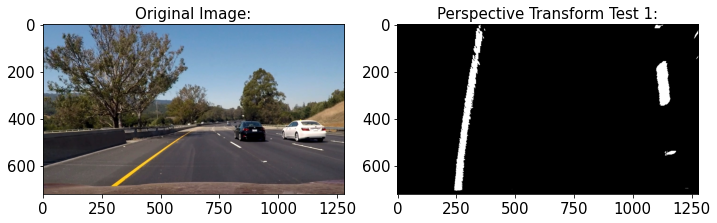

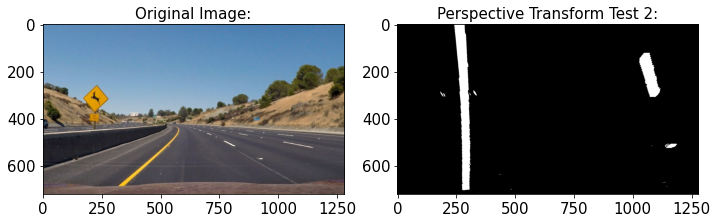

In [61]:
pipeline(op='Perspective Transform')


In [62]:
def get_histogram(warpedimage):
    return np.sum(warpedimage[warpedimage.shape[0]//2:,:], axis=0)

test_images  2


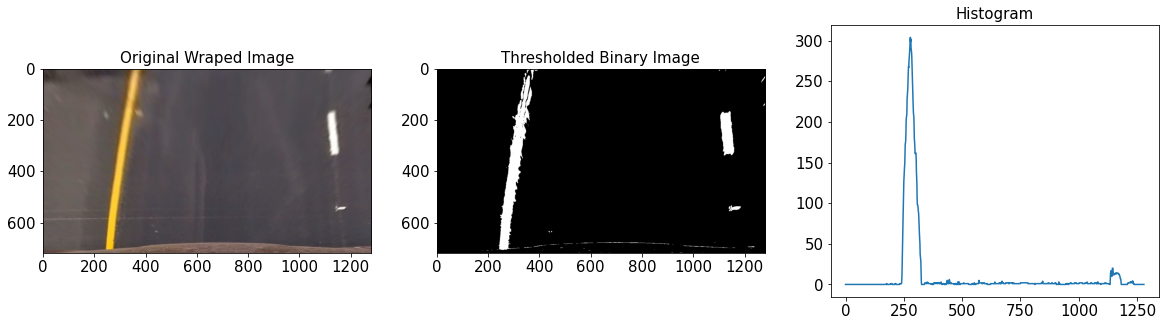

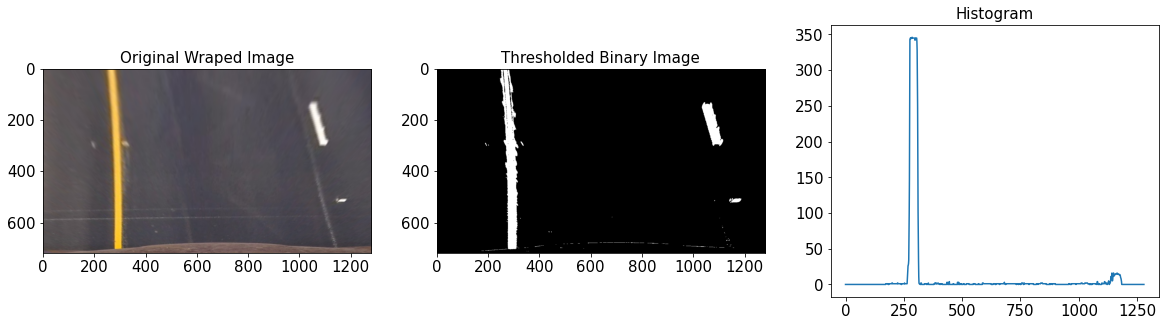

In [63]:
pipeline(op="Histogram")

In [71]:
# Set the hyperparameters

# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

# Method to get base points for left and right lanes
def get_lane_base_points(binary_warped): 
    # Take the histogram of bottom half of the image
    histogram = get_histogram(binary_warped)
    # Find the peaks of the left and right halves of the histogram 
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base, rightx_base, histogram

test = False

def find_lines(binary_warped, plot=False):

    # Make sure binary doesn't have float values
    binary_warped = binary_warped.astype('uint8')
    
    # Take a histogram of the bottom half of the image
    leftx_base, rightx_base, histogram = get_lane_base_points(binary_warped)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines

    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        if plot:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)         
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    # Color the lane line point (left line: red, right line: blue)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]  
        
    return out_img, left_fit, right_fit, left_fitx, right_fitx

test_images  2


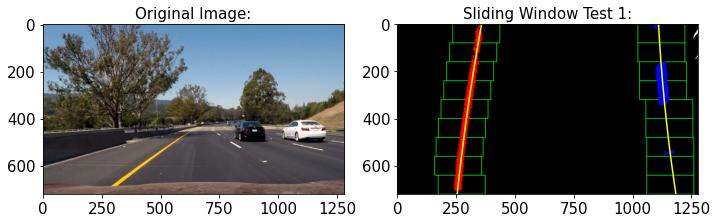

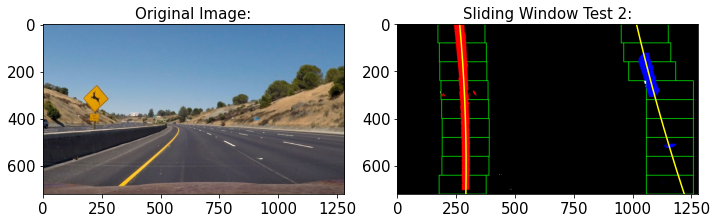

In [112]:
pipeline("Sliding Window")

In [73]:
def use_last_frame(binary_warped, left_fit, right_fit):

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 30
    left_lane_inds = (
        (nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] - margin)) &
        (nonzerox < (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] + margin)))
    right_lane_inds = (
        (nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] - margin)) &
        (nonzerox < (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
        
    return left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty, left_lane_inds, right_lane_inds

<h4> Detect lane pixels and fit to find the lane boundary </h4>

In [74]:
def visualize_lane_lines(binary_warped, left_fitx, right_fitx, ploty, left_lane_inds, right_lane_inds):
    # Make sure binary doesn't have float values
    binary_warped = binary_warped.astype('uint8')
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return result

In [76]:
pipeline('Shaded Lanes')

In [77]:
def draw_green_lane(original_image, binary_warped, left_fit, right_fit):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    h,w= binary_warped.shape
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    if len(left_fit) and len(right_fit):
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    



        ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
        cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, invert_matrix, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.5, 0)
    return result

In [79]:
#pipeline(op= 'Lane Mapping')

In [104]:
def calculate_curvature_radius(ploty, leftx, rightx, lefty, righty):
    
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curve_radius = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])
    right_curve_radius = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])
    radius = np.mean([left_curve_radius, right_curve_radius])

    left_y_max = np.argmax(lefty)
    right_y_max = np.argmax(righty)
    center_x = (leftx[left_y_max] + rightx[right_y_max])/2
    center_offset = (640 - center_x) * xm_per_pix
    
    
    return radius, center_offset

In [105]:
first = True
count = 0

def img_pipeline(image):

    undist = undistort(image)
    src, dst = source, destination
    
    warped = original2bird_eye(undist)
    warped_binary = combined_threshold(warped)
    
    global first, left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty
    if first:
     
        out_img, left_fit, right_fit, left_fitx, right_fitx = find_lines(warped_binary)
        left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty, _, _ = use_last_frame(warped_binary, left_fit, right_fit)
        first = False
        #left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty, left_lane_inds, right_lane_inds
    left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty, _, _ = use_last_frame(warped_binary, left_fit, right_fit)
    
    radius, center_offset = calculate_curvature_radius(ploty, leftx, rightx, lefty, righty)
    
    result = draw_green_lane(image,warped_binary, left_fit, right_fit)

    cv2.putText(result, 'Radius: {0:.1f}m '.format(np.add.reduce(radius) / count), (50, 50), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, bottomLeftOrigin=False)
    cv2.putText(result, 'Center Offset: {0:.2f}m'.format(np.add.reduce(center_offset) / count), (50, 100),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, bottomLeftOrigin=False)
    
    return result

In [106]:
def video_pipeline(video_file, output_file, process_method):
    """
    :param     video_file: source video file path
    :param    output_file: output video file path
    :param process_method: the callback function which is used to process the video per frame
    :return:
    """
    clip = VideoFileClip(video_file)
    processed_clip = clip.fl_image(process_method)  # NOTE: this function expects color images!!
    processed_clip.write_videofile(output_file, audio=False);

In [107]:
video_pipeline("project_video.mp4", "project_video_out4.mp4", img_pipeline);

t:   0%|          | 2/1260 [00:00<01:07, 18.51it/s, now=None]

Moviepy - Building video project_video_out4.mp4.
Moviepy - Writing video project_video_out4.mp4



Moviepy - Done !
Moviepy - video ready project_video_out4.mp4


In [ ]:
from IPython.display import Markdown, display
display(Markdown("writeup_template.md"))